In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using Plots

In [71]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_step.jl")

In [308]:
     
    true_var_coeff = [.6 .3;  .4 .7]
    true_trend_covariance = [(.015/400)^2 0 
                             0 (.02/400)^2]

    true_cycle_covariance = [.02^2 .0002
                            .0002 .015^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [.02^2 .0002
                                     .0002 .015^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    initial_state = [.02, .008]
    true_states, observations= sample(true_model,  240)

    n_presample = 40

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
 
 

200×4 Matrix{Float64}:
 0.295817  -1.28143  0.115994   0.137816
 0.29583   -1.28142  0.109367   0.147261
 0.295836  -1.28144  0.0974497  0.130872
 0.295815  -1.28144  0.108692   0.139578
 0.29585   -1.28139  0.0859152  0.120217
 0.295849  -1.28138  0.0642558  0.0910934
 0.295824  -1.28131  0.0710177  0.0931668
 0.295875  -1.2813   0.0793348  0.121138
 0.295903  -1.28128  0.117876   0.150939
 0.295935  -1.28121  0.159496   0.180654
 ⋮                              
 0.295909  -1.28181  0.186989   0.269527
 0.295918  -1.28179  0.191293   0.254121
 0.29593   -1.28186  0.201546   0.241881
 0.295861  -1.28183  0.216422   0.257464
 0.295921  -1.28185  0.166357   0.250865
 0.295928  -1.28177  0.183026   0.252041
 0.295921  -1.28178  0.17359    0.249517
 0.29585   -1.28183  0.184194   0.236197
 0.295868  -1.2818   0.17965    0.239206

In [309]:
mean(presample_data, dims=1)

1×2 Matrix{Float64}:
 0.402239  -0.850261

In [310]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 0.520669  -0.686864

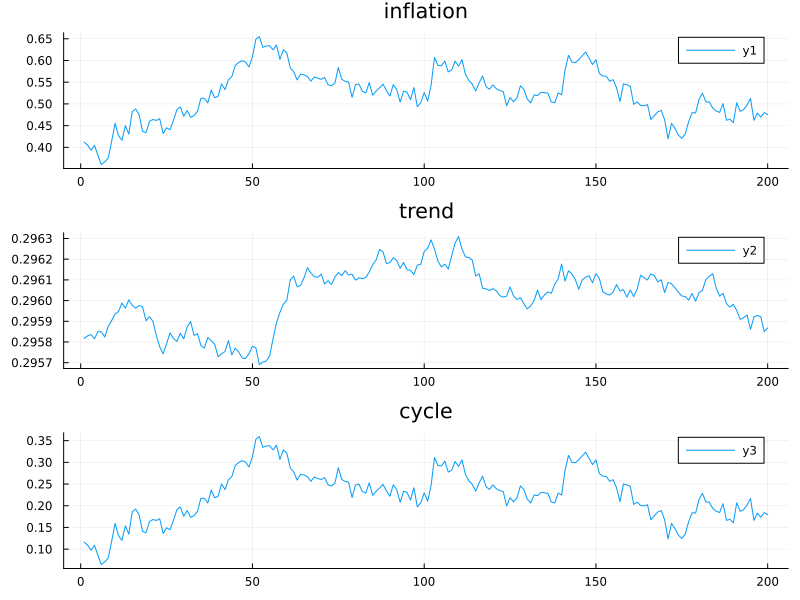

In [311]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

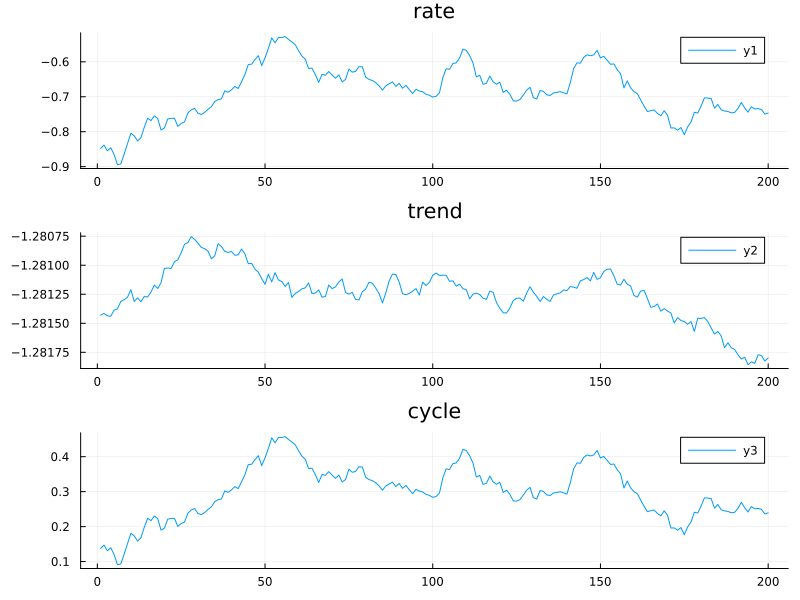

In [312]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [313]:
priors = (
        initial_trend_mean = mean(presample_data, dims=1)[1,:],
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2, 1].^2/400) * (priors.trend_covariance_df + 2 +1),
        )

(initial_trend_mean = [0.402239260433414, -0.8502610062291275], trend_covariance_df = 100, trend_covariance_mean = [1.03 0.0; 0.0 0.2575])

In [314]:
model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        priors.initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)

StateSpaceModel([1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.6 0.3; 0.0 0.0 0.4 0.7], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0], [1.0 0.0 1.0 0.0; 1.0 1.0 0.0 1.0], [1.4062499999999998e-9 0.0 0.0 0.0; 0.0 2.5e-9 0.0 0.0; 0.0 0.0 0.0004 0.0002; 0.0 0.0 0.0002 0.000225], [2.220446049250313e-16 0.0; 0.0 2.220446049250313e-16], [0.402239260433414, -0.8502610062291275, 0.0, 0.0], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 0.0004 0.0002; 0.0 0.0 0.0002 0.000225])

In [315]:
  state_filtered, covariance_filtred, state_predicted, covariance_predicted, ll = kalman_filter(model, data) 
   

   # Run Carter-Kohn sampler
    println("Running Carter-Kohn sampler...")
    state_smoothed_samples = carter_kohn_sampler(model, data, n_samples=10_000)
   
    # Compute posterior statistics
    state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  
 

Running Carter-Kohn sampler...


([0.39735752719751 -1.2481453522837862 0.01445329986260466 0.002990438841420839; 0.39735771666316133 -1.2481456535687294 0.007839250344700108 0.012462932725835702; … ; 0.3973718017771277 -1.248209749892169 0.08267142516311954 0.10105906986726715; 0.39737181376198333 -1.248210321244508 0.07814654352295872 0.10411319446746851], [0.3644658382386188 -1.2592799198423041 -0.018384473008963606 -0.04085545406091773; 0.36450966735360196 -1.2592794845034945 -0.024991565444947846 -0.03137478703787518; … ; 0.3645048364489418 -1.2593690366665369 0.04969293858141093 0.05715875447926293; 0.3644885442770244 -1.2593908302965156 0.04515605580668829 0.06019356736503244], [0.4301864211582136 -1.2369063252943353 0.0473334886490281 0.04624621525759033; 0.430196630617256 -1.2369238641688602 0.040689215802518115 0.05569593624956532; … ; 0.4303412152215533 -1.237043168448788 0.11554366061953658 0.14463295746550414; 0.43036233687197545 -1.2370250536688525 0.1110298541926873 0.14765007107558098])

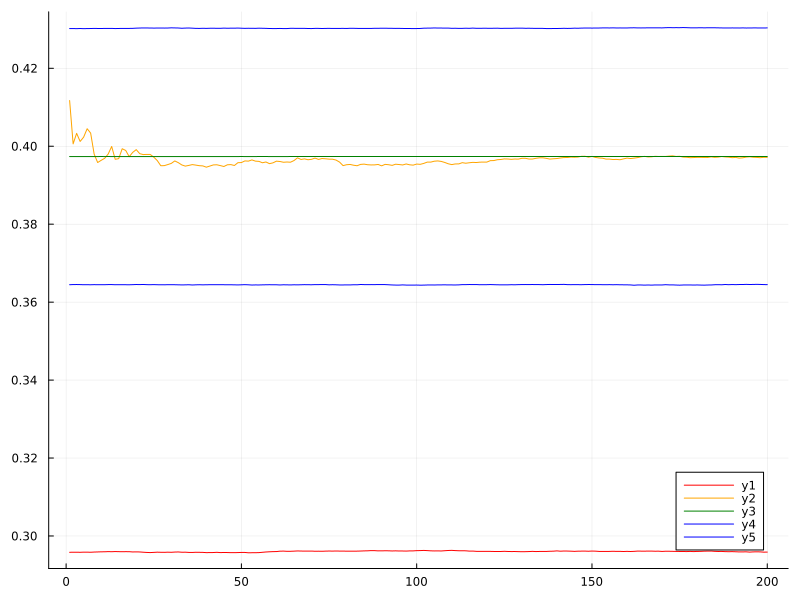

In [316]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

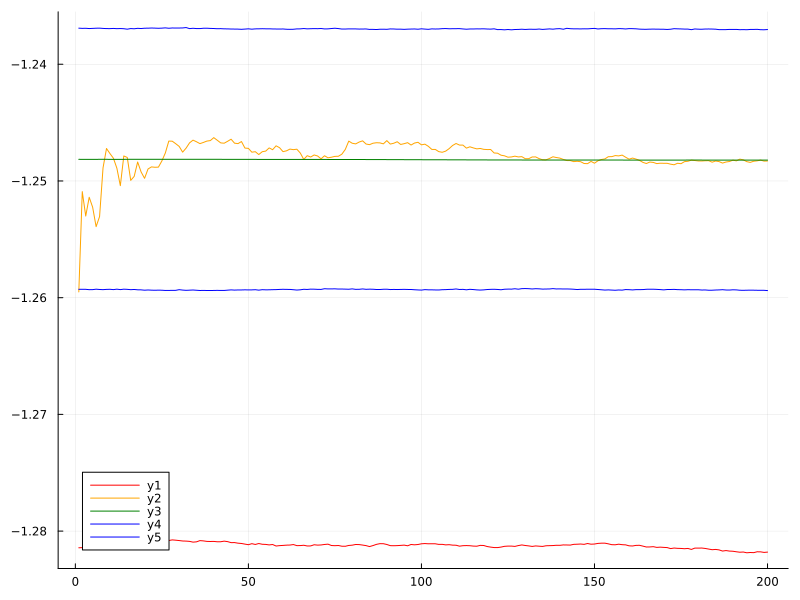

In [317]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

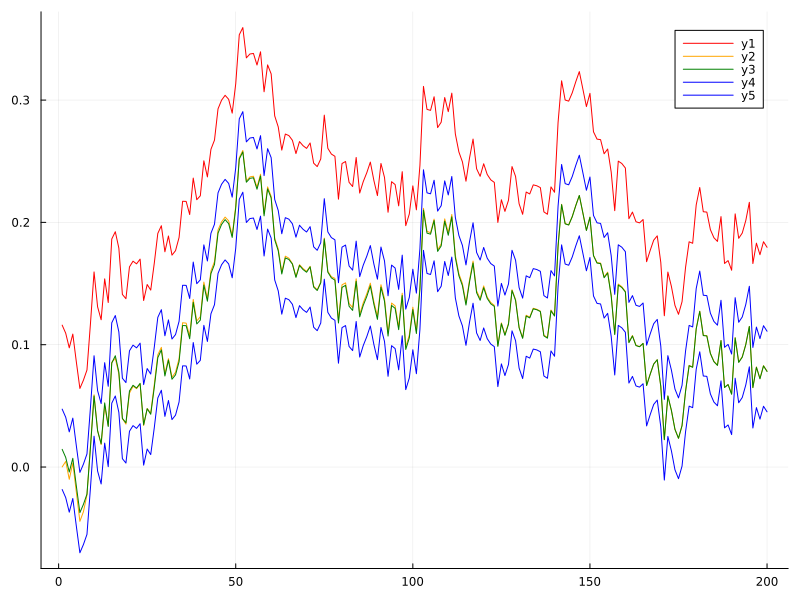

In [318]:
st = 3
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

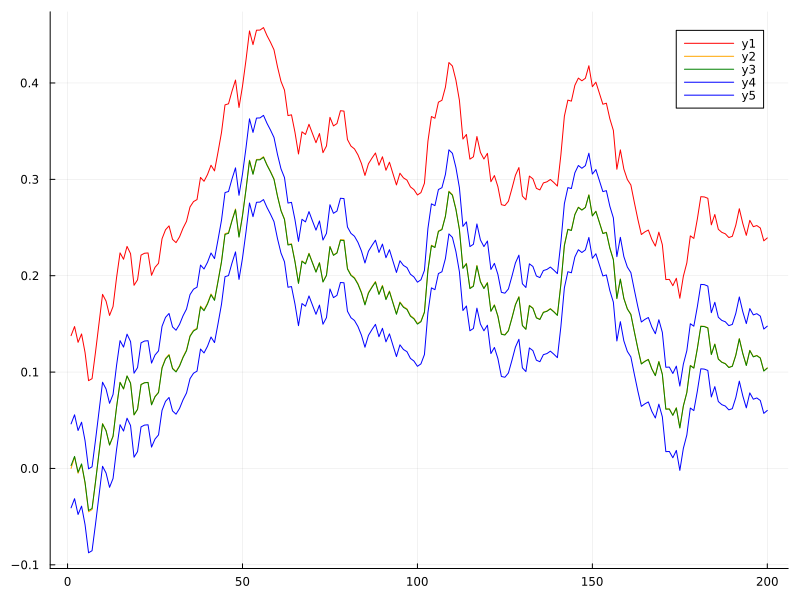

In [319]:
st = 4
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_filtered[:,st]; color="orange")
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

In [320]:
var_priors = minnesota_priors(data, λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])
reshape(var_priors, 3, 2)

3×2 Matrix{Normal}:
 Normal{Float64}(μ=0.0, σ=0.2)        Normal{Float64}(μ=0.0, σ=0.260972)
 Normal{Float64}(μ=0.0, σ=0.153273)   Normal{Float64}(μ=0.0, σ=0.2)
 Normal{Float64}(μ=0.0, σ=0.0117864)  Normal{Float64}(μ=0.0, σ=0.0153797)

In [337]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 2.6567320934148235e-7
 4.6674445697610465e-7

2-element Vector{Float64}:
 0.0005154349710113608
 0.0006831869853679186

In [322]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,2]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 299.0
Ψ: [1.0300002656732095 -6.99508392654994e-9; -6.99508392654994e-9 0.257500466744457]
)


In [336]:
cov_posterior = zeros(10_000, 2)

for n in 1:10_000
  cov_posterior[n,:,:] = diag(rand(post_dist))
end


display(mean(cov_posterior, dims=1))
display(mean(cov_posterior, dims=1).^.5 .* [200^.5,400^.5]) 

1×2 Matrix{Float64}:
 0.00347681  0.000870249

2×2 Matrix{Float64}:
 0.833883  0.417193
 1.17929   0.59

In [335]:
true_trend_covariance .^.5

2×2 Matrix{Float64}:
 3.75e-5  0.0
 0.0      5.0e-5

In [334]:
stds = zeros(10_000, 2)


for n in 1:10_000
    stds = diag(rand(InverseWishart(priors.trend_covariance_df, priors.trend_covariance_mean)))
end

display(mean(stds, dims=1).^.5 *10)
display(mode(stds[1]) ^.5 * 10) 


1-element Vector{Float64}:
 0.8634037856377124

1.1017994596778782